## Compression with ZFP and FPZIP

In [1]:
import zfpy
import fpzip
import numpy as np
from lossycomp.plots import mult_plot, single_plot, plot_history

In [2]:
##### ZFP - LOSSLESS ######
my_array = np.arange(1, 20)
compressed_data = zfpy.compress_numpy(my_array)
decompressed_array = zfpy.decompress_numpy(compressed_data)

# confirm lossless compression/decompression
np.testing.assert_array_equal(my_array, decompressed_array)

print("ZFP - LOSSLESS")
print("# Bytes data:", my_array.nbytes)
print("# Bytes compressed data:", len(compressed_data)) 
print("# Bytes decompressed data:", decompressed_array.nbytes)

ZFP - LOSSLESS
# Bytes data: 152
# Bytes compressed data: 64
# Bytes decompressed data: 152


In [3]:
##### ZFP - LOSSY ######
compressed_data = zfpy.compress_numpy(my_array, tolerance=1e-3)
decompressed_array = zfpy.decompress_numpy(compressed_data)

# Note the change from "equal" to "allclose" due to the lossy compression
#np.testing.assert_array_equal(my_array, decompressed_array)

print("ZFP - LOSSY")
print("# Bytes data:", my_array.nbytes)
print("# Bytes compressed data:", len(compressed_data))
print("# Bytes decompressed data:", decompressed_array.nbytes)

ZFP - LOSSY
# Bytes data: 152
# Bytes compressed data: 64
# Bytes decompressed data: 152


In [4]:
np.testing.assert_allclose(my_array, decompressed_array, atol=1)  #It works ith atol=1??

In [5]:
##### FPZIP - LOSSY ######
data = np.array(np.arange(1, 20), dtype=np.float32) # up to 4d float or double array
# Compress data losslessly, interpreting the underlying buffer in C (default) or F order.
compressed_bytes = fpzip.compress(data, precision=16, order='C') # returns byte string
# Back to 3d or 4d float or double array, decode as C (default) or F order.
data_again = fpzip.decompress(compressed_bytes, order='C') 
print("FPZIP - LOSSY")
print("# Bytes data:", data.nbytes)
print("# Bytes compressed data:", len(compressed_bytes)) #is that how you meassure how many bytes? 
print("# Bytes decompressed data:", data_again[0,0,0].nbytes) 

FPZIP - LOSSY
# Bytes data: 76
# Bytes compressed data: 52
# Bytes decompressed data: 76


In [6]:
np.testing.assert_allclose(data, data_again[0,0,0], atol=1e-03)

## Testing with climate Data

In [2]:
import xarray as xr
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1980-01-14T16:00:00','1980-01-15T07:00:00'),level = slice(978,1000), longitude=slice(6,17.75), latitude=slice(55.5,43.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = test_data['t'].values
test_data.shape

(16, 48, 48, 1)

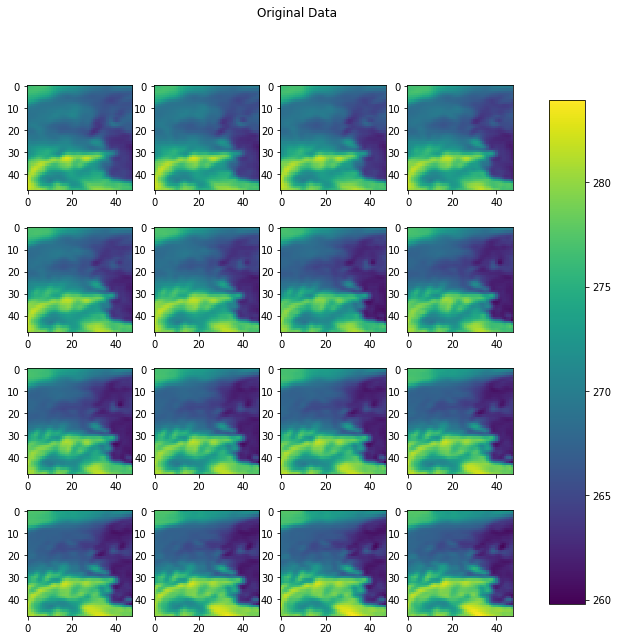

In [84]:
test_data = np.expand_dims(test_data, axis=0)
mult_plot(test_data, 4, 4, "Original Data", test_data.min(), test_data.max())

In [57]:
compressed_bytes = fpzip.compress(test_data, precision=16, order='C') # returns byte string max 32 precision?
data_again = fpzip.decompress(compressed_bytes, order='C') 

In [58]:
print("# Bytes data:", test_data.nbytes)
print("# Bytes compressed data:", len(compressed_bytes))
print("# Bytes decompressed data:", data_again.nbytes) 

# Bytes data: 147456
# Bytes compressed data: 5658
# Bytes decompressed data: 147456


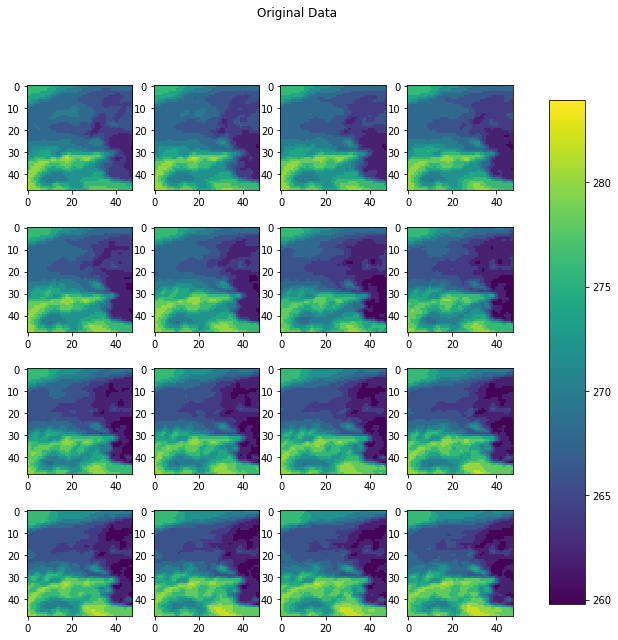

In [59]:
data_again = np.expand_dims(data_again, axis=0)
mult_plot(data_again, 4, 4, "Original Data", test_data.min(), test_data.max())

In [30]:
help(zfpy.compress_numpy)

Help on built-in function compress_numpy in module zfpy:

compress_numpy(...)
    compress_numpy(ndarray arr, double tolerance=-1, double rate=-1, int precision=-1, write_header=True) -> bytes



In [80]:
compressed_data = zfpy.compress_numpy(test_data, precision=8)
decompressed_array = zfpy.decompress_numpy(compressed_data)

In [81]:
print("# Bytes data:", test_data.nbytes)
print("# Bytes compressed data:", len(compressed_data))
print("# Bytes decompressed data:", decompressed_array.nbytes) 

# Bytes data: 147456
# Bytes compressed data: 1816
# Bytes decompressed data: 147456


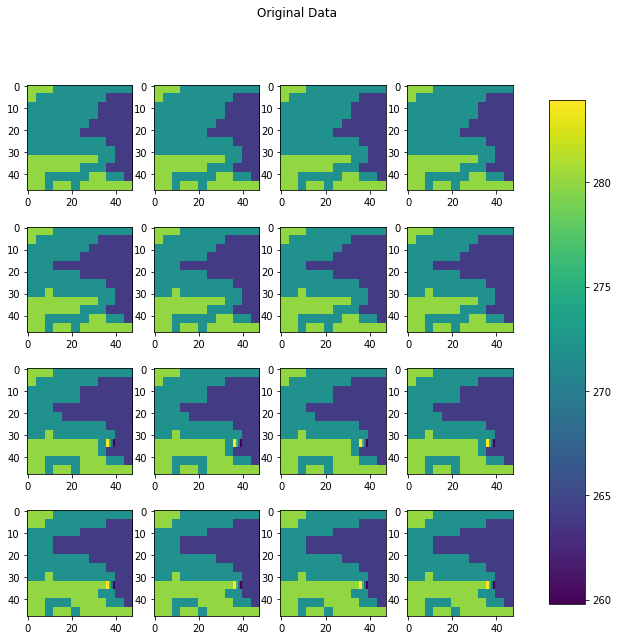

In [82]:
decompressed_array = np.expand_dims(decompressed_array, axis=0)
mult_plot(decompressed_array, 4, 4, "Original Data", test_data.min(), test_data.max())

In [83]:
help(fpzip.compress)

Help on built-in function compress in module fpzip:

compress(...)
    fpzip.compress(data, precision=0, order='C')
    
    Takes up to a 4d numpy array of floats or doubles and returns
    a compressed bytestring.
    
    precision indicates the number of bits to truncate. Any value above
    zero indicates a lossy operation.
    
    order is 'C' or 'F' (row major vs column major memory layout) and 
    should correspond to the underlying orientation of the input array.

